In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "theroyakash"
os.environ['KAGGLE_KEY'] = "CONFIDENTIAL"

!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

In [ ]:
!nvidia-smi

Fri Sep 11 01:03:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls

sample_data  stanford-dogs-dataset.zip


In [ ]:
!unzip '/content/stanford-dogs-dataset.zip'

In [ ]:
!ls

annotations  images  sample_data  stanford-dogs-dataset.zip


In [ ]:
input_path= '/content/images/Images'

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
image_size = (200, 200)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images/Images",
    validation_split=0.2,
    subset="training",
    label_mode = 'int',
    seed = 1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/images/Images",
    validation_split=0.2,
    subset="validation",
    label_mode = 'int',
    seed =1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


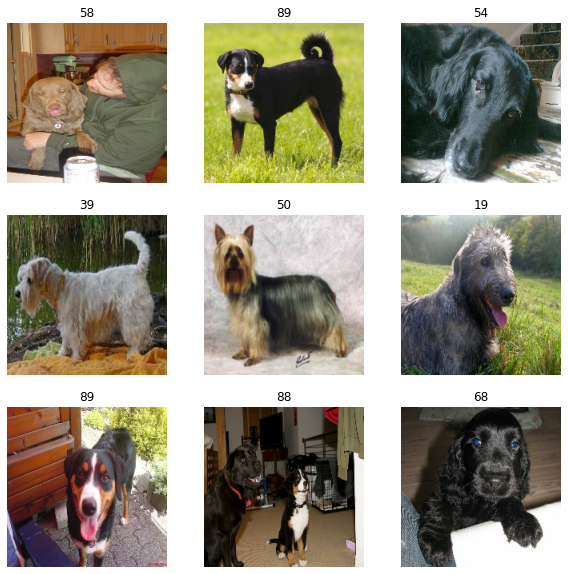

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation_train = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.Rescaling(scale =1./255),
        layers.experimental.preprocessing.RandomHeight(0.1),
        layers.experimental.preprocessing.RandomWidth(0.1)
     
    ]
)

In [ ]:
data_augmentation_test = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(scale =1./255)
     
    ]
)

In [ ]:
#Inception V3 

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(200,200,3),
                                               include_top=False,
                                               weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

87916544/87910968 [==============================] - 2s 0us/step


In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation_train(x, training=True), y))

augmented_val_ds = val_ds.map(
  lambda x, y: (data_augmentation_test(x, training=True), y))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras import regularizers

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
Dl_1 = tf.keras.layers.Dropout(rate = 0.2)
prediction_layer = tf.keras.layers.Dense(120,activation='softmax')

model_V3 = tf.keras.Sequential([
  pre_trained_model,
  global_average_layer,
  Dl_1,
  prediction_layer
])

model_V3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_V3.summary()

# Callbacks

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
history = model_V3.fit(
           augmented_train_ds.repeat(), steps_per_epoch=int(8000/batch_size), 
           epochs=30, validation_data=augmented_val_ds.repeat(),
           validation_steps=int(2000/batch_size) , callbacks=[lr_reduce])

Epoch 1/30
125/125 [==============================] - 99s 789ms/step - loss: 2.3413 - accuracy: 0.4658 - val_loss: 1.0573 - val_accuracy: 0.7016
Epoch 2/30
125/125 [==============================] - 85s 679ms/step - loss: 1.5663 - accuracy: 0.6074 - val_loss: 1.0349 - val_accuracy: 0.7182
Epoch 3/30
125/125 [==============================] - 80s 638ms/step - loss: 1.3900 - accuracy: 0.6474 - val_loss: 1.0555 - val_accuracy: 0.7359
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 1.4016 - accuracy: 0.6466
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
125/125 [==============================] - 77s 614ms/step - loss: 1.4016 - accuracy: 0.6466 - val_loss: 1.0448 - val_accuracy: 0.7303
Epoch 5/30
125/125 [==============================] - 75s 603ms/step - loss: 1.0944 - accuracy: 0.7032 - val_loss: 0.8695 - val_accuracy: 0.7540
Epoch 6/30
125/125 [==============================] - 72s 574ms/step - loss: 1.0649 - accuracy: 0.7094 - val_

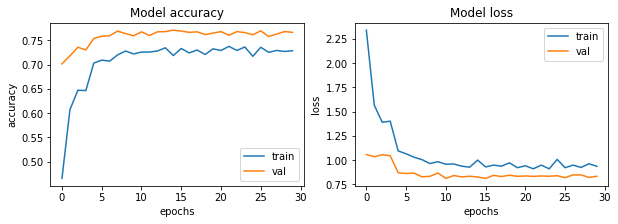

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])